<a href="https://colab.research.google.com/github/chanon9945/RIIC_demo/blob/main/RIIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import seaborn as sns
import random
from itertools import combinations
import io

In [2]:
!pip install deap
from deap import base, creator, tools, algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.0 MB/s eta 0:00:00


In [3]:
!wget https://github.com/chanon9945/RIIC_demo/raw/refs/heads/main/entry1.csv -O entry1.csv

--2025-03-11 13:46:58--  https://github.com/chanon9945/RIIC_demo/raw/refs/heads/main/entry1.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chanon9945/RIIC_demo/refs/heads/main/entry1.csv [following]
--2025-03-11 13:46:59--  https://raw.githubusercontent.com/chanon9945/RIIC_demo/refs/heads/main/entry1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5543 (5.4K) [text/plain]
Saving to: ‘entry1.csv’

entry1.csv          100%[===================>]   5.41K  --.-KB/s    in 0s      

2025-03-11 13:46:59 (37.4 MB/s) - ‘entry1.csv’ saved [5543/5543]



In [4]:
entry = pd.read_csv('entry1.csv')
entry.head()

,name,gender,sexual_orientation,hobbies,favorite_sports,favorite_musician,age,city,education_level,relationship_status
0,Alice Smith,Female,Heterosexual,"reading, traveling, cooking",soccer,Taylor Swift,28,New York,Bachelor,Single
1,Bob Johnson,Male,Heterosexual,"gaming, sports, hiking",basketball,Drake,32,Los Angeles,Bachelor,Married
2,Carol Williams,Female,Heterosexual,"painting, photography",tennis,Adele,25,Chicago,Master,Single
3,David Brown,Male,Heterosexual,"cooking, traveling, reading",baseball,The Beatles,45,Houston,High School,Married
4,Emily Jones,Female,Heterosexual,"dancing, music, traveling",running,Lady Gaga,30,Phoenix,Bachelor,In a relationship


In [5]:
def create_passage(row):
    """
    Constructs a passage string from a row of data.

    Expects the row to have the following keys:
    'name', 'gender', 'sexual_orientation', 'hobbies',
    'favorite_sports', 'favorite_musician', 'age', 'city',
    'education_level', 'relationship_status'
    """
    passage = (
        f"{row['name']} is a {row['age']}-year-old {row['gender']} with a {row['sexual_orientation']} orientation. "
        f"They enjoy {row['hobbies']}, and their favorite sport is {row['favorite_sports']}. "
        f"They love listening to {row['favorite_musician']} and live in {row['city']}. "
        f"Education level: {row['education_level']}, Relationship status: {row['relationship_status']}."
    )
    return passage

In [6]:
#combine the entry as strings
passage_entry = []
for index, row in entry.iterrows():
  passage_entry.append(create_passage(row))

In [7]:
#embed the strings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(passage_entry)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
#calculate the dot product and store as a matrix
dot_product_matrix = np.dot(embeddings, embeddings.T)/2

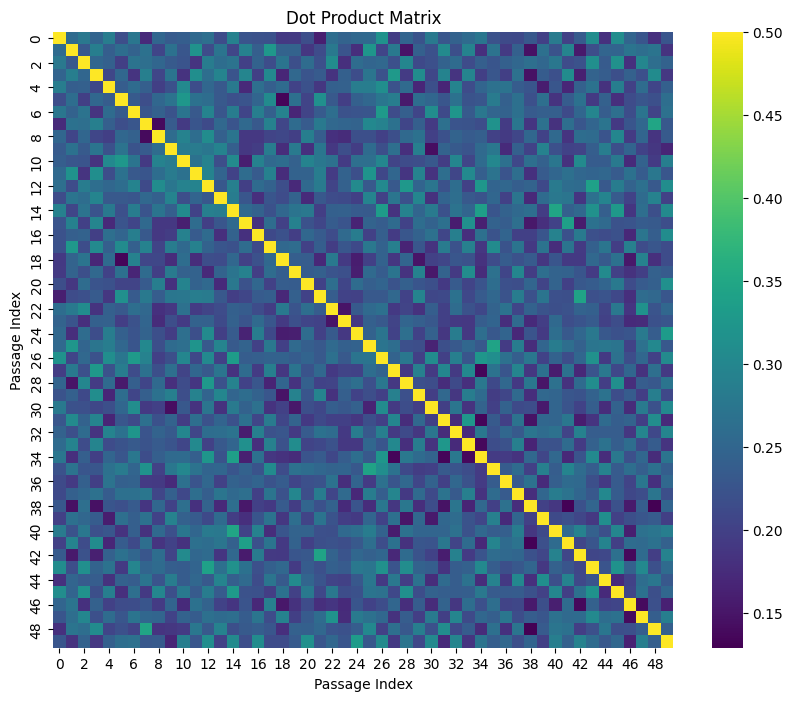

In [9]:
#plot the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dot_product_matrix, cmap='viridis', annot=False)
plt.title("Dot Product Matrix")
plt.xlabel("Passage Index")
plt.ylabel("Passage Index")
plt.show()

In [17]:
n = dot_product_matrix.shape[0] #number of individuals
group_size = 5
num_groups = n // group_size  # should be 10 groups

# Define an evaluation function that computes the average similarity for a group.
def evaluate_group_from_ordered_matrix(group_indices):
    total_similarity = 0
    for i, j in combinations(group_indices, 2):
        total_similarity += dot_product_matrix[i, j]
    # For a group of 5, there are 10 pairs (C(5,2)=10)
    avg_similarity = total_similarity / 10.0
    return float(avg_similarity),

# Create fitness and individual types (maximization)
if not hasattr(creator, "FitnessMax"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
# Each individual is a random permutation of all n individuals
toolbox.register("individual", tools.initIterate, creator.Individual,
                 lambda: random.sample(range(n), n))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_group_from_ordered_matrix)
toolbox.register("select", tools.selTournament, tournsize=3)
# Use a built-in ordered crossover which is suited for permutation problems
toolbox.register("mate", tools.cxOrdered)
# Use a mutation that shuffles a subset of indices
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)

# Create an initial population
population = toolbox.population(n=50)

# GA parameters
NGEN = 1000
CXPB = 0.7  # Crossover probability
MUTPB = 0.2  # Mutation probability

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = list(map(toolbox.evaluate, offspring))

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))

# Extract the best individual (partition)
best_individual = tools.selBest(population, k=1)[0]
best_fitness = toolbox.evaluate(best_individual)[0]

print("Best partition (all 10 groups):")
for i in range(num_groups):
    group = best_individual[i * group_size : (i + 1) * group_size]
    print(f"Group {i + 1}: {group}")

print("Maximum total similarity:", best_fitness)

Best partition (all 10 groups):
Group 1: [8, 27, 25, 48, 47]
Group 2: [49, 4, 1, 32, 23]
Group 3: [21, 45, 35, 24, 7]
Group 4: [28, 19, 17, 10, 44]
Group 5: [37, 40, 14, 42, 26]
Group 6: [29, 31, 6, 33, 0]
Group 7: [36, 34, 5, 20, 41]
Group 8: [22, 15, 13, 46, 12]
Group 9: [18, 39, 38, 9, 16]
Group 10: [3, 11, 2, 30, 43]
Maximum total similarity: 28.979989866912366


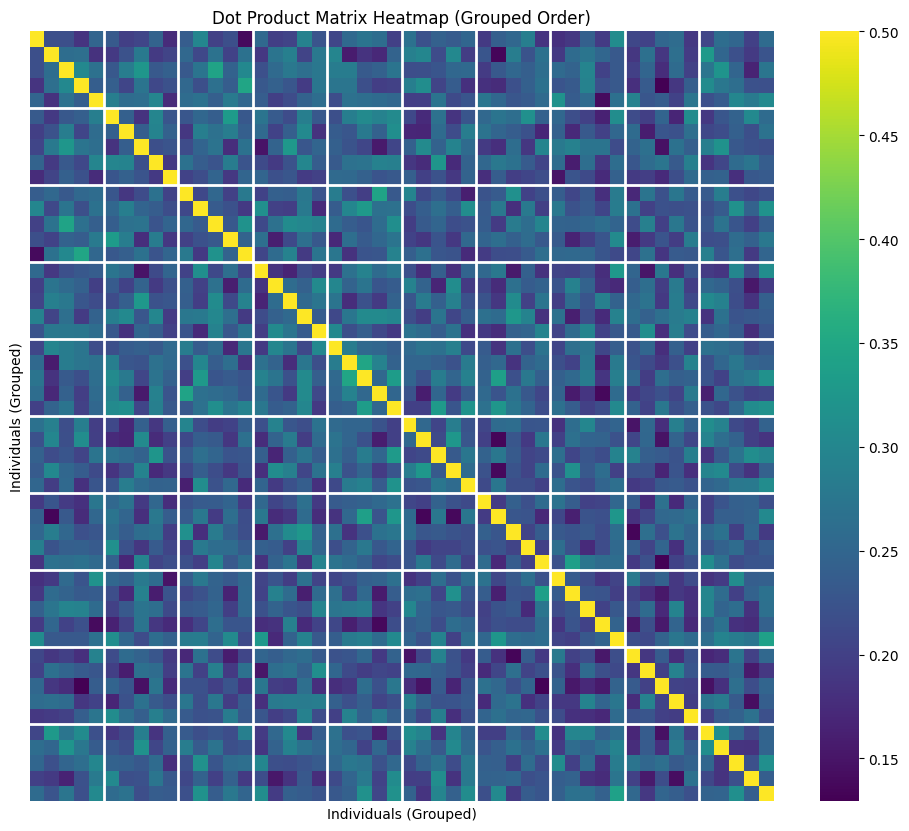

In [18]:
# Reorder the dot product matrix using the best partition ordering
ordered_indices = best_individual  # best_individual is a list of 50 indices
ordered_matrix = dot_product_matrix[np.ix_(ordered_indices, ordered_indices)]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(ordered_matrix, cmap='viridis', annot=False, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title("Dot Product Matrix Heatmap (Grouped Order)")
plt.xlabel("Individuals (Grouped)")
plt.ylabel("Individuals (Grouped)")

# Optionally, add lines to visually separate groups (every 5 rows/columns)
for i in range(1, num_groups):
    plt.axhline(i * group_size, color='white', lw=2)
    plt.axvline(i * group_size, color='white', lw=2)

plt.show()

<ipython-input-19-b9dfe6132e06>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  block_matrix[i, j] = (group_fitnesses[i] + group_fitnesses[j]) / 2


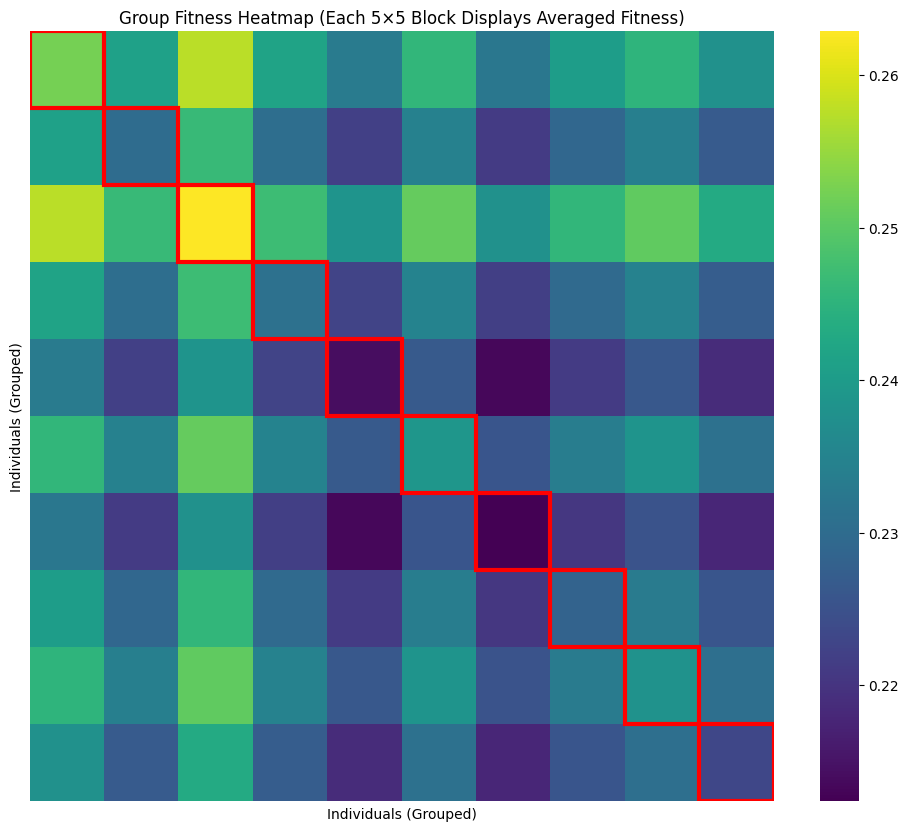

In [19]:
# Compute the fitness (total similarity) for each group in the ordered matrix.
# In the ordered matrix, groups are contiguous. For group i, the indices are:
# [i*group_size, i*group_size+1, ..., (i+1)*group_size - 1]
group_fitnesses = []
for i in range(num_groups):
    group_indices = list(range(i * group_size, (i + 1) * group_size))
    fitness_val = evaluate_group_from_ordered_matrix(group_indices)
    group_fitnesses.append(fitness_val)
group_fitnesses = np.array(group_fitnesses)  # shape: (10,)

# Create a 10x10 block matrix where each block (i, j) is the average of
# group i and group j fitness values.
block_matrix = np.zeros((num_groups, num_groups))
for i in range(num_groups):
    for j in range(num_groups):
        block_matrix[i, j] = (group_fitnesses[i] + group_fitnesses[j]) / 2

# Expand the 10x10 block matrix to a 50x50 matrix.
# Each cell in block_matrix becomes a group_size x group_size block with the same value.
full_heatmap = np.kron(block_matrix, np.ones((group_size, group_size)))

# Plot the heatmap without annotations.
plt.figure(figsize=(12, 10))
ax = sns.heatmap(full_heatmap, cmap='viridis', annot=False, cbar=True,
                 xticklabels=False, yticklabels=False)
plt.title("Group Fitness Heatmap (Each 5×5 Block Displays Averaged Fitness)")
plt.xlabel("Individuals (Grouped)")
plt.ylabel("Individuals (Grouped)")

# Highlight each diagonal 5x5 block with a red border.
for i in range(num_groups):
    x = i * group_size
    y = i * group_size
    rect = plt.Rectangle((x, y), group_size, group_size, fill=False, edgecolor='red', lw=3)
    ax.add_patch(rect)

plt.show()

In [ ]:
group_csvs = {}

for i in range(num_groups):
    group_indices = best_individual[i * group_size : (i + 1) * group_size]
    group_df = entry.iloc[group_indices].reset_index(drop=True)
    csv_text = group_df.to_csv(index=False)
    group_csvs[f"Group_{i+1}"] = csv_text
    print(f"Group {i+1}:")
    print(csv_text)
    print("-" * 40)

Group 1:
name,gender,sexual_orientation,hobbies,favorite_sports,favorite_musician,age,city,education_level,relationship_status
Susan Jackson,Female,Homosexual,"cooking, dancing, reading",tennis,Adele,35,Dallas,Bachelor,Single
Grace Miller,Female,Heterosexual,"yoga, meditation, reading",tennis,Adele,33,San Antonio,Master,Married
Vanessa Parker,Female,Heterosexual,"reading, traveling, cooking",tennis,Adele,33,New York,Bachelor,Single
Emily Jones,Female,Heterosexual,"dancing, music, traveling",running,Lady Gaga,30,Phoenix,Bachelor,In a relationship
Xavier White,Male,Bisexual,"gaming, sports, hiking",baseball,The Beatles,41,Houston,High School,Married

----------------------------------------
Group 2:
name,gender,sexual_orientation,hobbies,favorite_sports,favorite_musician,age,city,education_level,relationship_status
Queenie Taylor,Non-Binary,Bisexual,"dancing, music, art",running,Lady Gaga,24,San Antonio,Bachelor,Single
Nathan Wilson,Male,Heterosexual,"traveling, music, sports",baseball,T

In [ ]:
group1_csv = group_csvs["Group_1"]
group1_df = pd.read_csv(io.StringIO(group1_csv))
group1_df.head()

,name,gender,sexual_orientation,hobbies,favorite_sports,favorite_musician,age,city,education_level,relationship_status
0,Susan Jackson,Female,Homosexual,"cooking, dancing, reading",tennis,Adele,35,Dallas,Bachelor,Single
1,Grace Miller,Female,Heterosexual,"yoga, meditation, reading",tennis,Adele,33,San Antonio,Master,Married
2,Vanessa Parker,Female,Heterosexual,"reading, traveling, cooking",tennis,Adele,33,New York,Bachelor,Single
3,Emily Jones,Female,Heterosexual,"dancing, music, traveling",running,Lady Gaga,30,Phoenix,Bachelor,In a relationship
4,Xavier White,Male,Bisexual,"gaming, sports, hiking",baseball,The Beatles,41,Houston,High School,Married
